# Quick Uninstall Analysis

This notebook analyzes users who uninstalled the extension very quickly (within 5 minutes of installation).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set style for plots
plt.style.use('ggplot')
sns.set(style='whitegrid')

In [2]:
# Load the data
df = pd.read_csv('analytics.csv')

# Display basic information about the dataset
print(f"Total number of records: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
df.head()

Total number of records: 10992
Columns: ['id', 'type', 'url', 'payload', 'user_id', 'session_id', 'received_at', 'created_at', 'domain']

Data types:
id              int64
type           object
url            object
payload        object
user_id        object
session_id     object
received_at    object
created_at     object
domain         object
dtype: object


,id,type,url,payload,user_id,session_id,received_at,created_at,domain
0,16926,time-spent,www.amazon.com/Amazon-Brand-Decorative-Decorat...,"{""duration"":738}",98ec858e-c25a-4c2a-a588-cfe9cf8a1fb9,b1d23a46-7793-48b7-bfef-02d2bf61309c,2025-03-14T00:03:23.770546+00:00,2025-03-14T00:03:18.47+00:00,amazon.com
1,16927,time-spent,www.amazon.com/Amazon-Brand-Decorative-Decorat...,"{""duration"":4447}",98ec858e-c25a-4c2a-a588-cfe9cf8a1fb9,b1d23a46-7793-48b7-bfef-02d2bf61309c,2025-03-14T00:03:27.312308+00:00,2025-03-14T00:03:22.917+00:00,amazon.com
2,16928,uninstall,www.lessextension.com/goodbye,NaN,98ec858e-c25a-4c2a-a588-cfe9cf8a1fb9,none,2025-03-14T00:03:34.022325+00:00,2025-03-14T00:03:29.737+00:00,lessextension.com
3,16944,on-onboarding,www.lessextension.com/onboarding,NaN,none,none,2025-03-14T16:00:23.615042+00:00,2025-03-14T16:00:22.709+00:00,lessextension.com
4,16945,on-onboarding,www.lessextension.com/onboarding,NaN,none,none,2025-03-14T17:55:19.528221+00:00,2025-03-14T17:55:19.168+00:00,lessextension.com


In [3]:
# Convert timestamp columns to datetime
df['received_at'] = pd.to_datetime(df['received_at'])
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', infer_datetime_format=True)

# Count event types
event_counts = df['type'].value_counts()
print("Event type distribution:")
event_counts

Event type distribution:


/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_39191/333821806.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', infer_datetime_format=True)


type
time-spent                    8962
page-view                      888
from-directs                   514
on-onboarding                  286
from-directs-cta                90
open-popup                      62
add-to-cart                     44
uninstall                       38
active                          28
welcome-modal-seen              28
enforce_wait_modal_shown        19
enforce_wait_canceled            9
enforce_wait_info_expanded       9
open-options                     5
place-order                      5
questionary-popup                4
cancel                           1
Name: count, dtype: int64

In [4]:
# Identify onboarding and uninstall events
onboarding_events = df[df['type'] == 'on-onboarding'].copy()
uninstall_events = df[df['type'] == 'uninstall'].copy()

print(f"Total onboarding events: {len(onboarding_events)}")
print(f"Total uninstall events: {len(uninstall_events)}")

Total onboarding events: 286
Total uninstall events: 38


In [5]:
# Focus on users who have user_id values (not 'none')
valid_onboarding = onboarding_events[onboarding_events['user_id'] != 'none'].copy()
valid_uninstalls = uninstall_events[uninstall_events['user_id'] != 'none'].copy()

print(f"Valid onboarding events: {len(valid_onboarding)}")
print(f"Valid uninstall events: {len(valid_uninstalls)}")

Valid onboarding events: 0
Valid uninstall events: 38


In [6]:
# Create a dictionary of users with their first onboarding time
user_first_onboarding = {}
for _, row in valid_onboarding.iterrows():
    user_id = row['user_id']
    time = row['created_at']
    if user_id not in user_first_onboarding or time < user_first_onboarding[user_id]:
        user_first_onboarding[user_id] = time

# In case we don't have explicit onboarding events for some users,
# let's also check the first activity of any kind
user_first_activity = {}
for _, row in df[df['user_id'] != 'none'].iterrows():
    user_id = row['user_id']
    time = row['created_at']
    if user_id not in user_first_activity or time < user_first_activity[user_id]:
        user_first_activity[user_id] = time

# For each user, get their installation time (either from onboarding or first activity)
user_install_time = {}
for user_id in user_first_activity.keys():
    if user_id in user_first_onboarding:
        user_install_time[user_id] = user_first_onboarding[user_id]
    else:
        user_install_time[user_id] = user_first_activity[user_id]

print(f"Total users with identified installation time: {len(user_install_time)}")

Total users with identified installation time: 77


In [7]:
# Calculate the time to uninstall for each user
uninstall_times = []

for _, row in valid_uninstalls.iterrows():
    user_id = row['user_id']
    uninstall_time = row['created_at']
    
    if user_id in user_install_time:
        install_time = user_install_time[user_id]
        time_diff = (uninstall_time - install_time).total_seconds() / 60  # Convert to minutes
        
        uninstall_times.append({
            'user_id': user_id,
            'install_time': install_time,
            'uninstall_time': uninstall_time,
            'minutes_to_uninstall': time_diff
        })

# Convert to DataFrame
uninstall_df = pd.DataFrame(uninstall_times)

# Sort by time to uninstall
if not uninstall_df.empty:
    uninstall_df = uninstall_df.sort_values('minutes_to_uninstall')
    
    print(f"Total users with calculated uninstall time: {len(uninstall_df)}")
    uninstall_df.head(10)

Total users with calculated uninstall time: 38


In [8]:
# Identify users who uninstalled within 5 minutes
if not uninstall_df.empty:
    quick_uninstalls = uninstall_df[uninstall_df['minutes_to_uninstall'] <= 5]
    
    print(f"Number of users who uninstalled within 5 minutes: {len(quick_uninstalls)}")
    print(f"Percentage of all uninstalls: {len(quick_uninstalls) / len(uninstall_df) * 100:.2f}%")
    
    quick_uninstalls.head(10)

Number of users who uninstalled within 5 minutes: 27
Percentage of all uninstalls: 71.05%


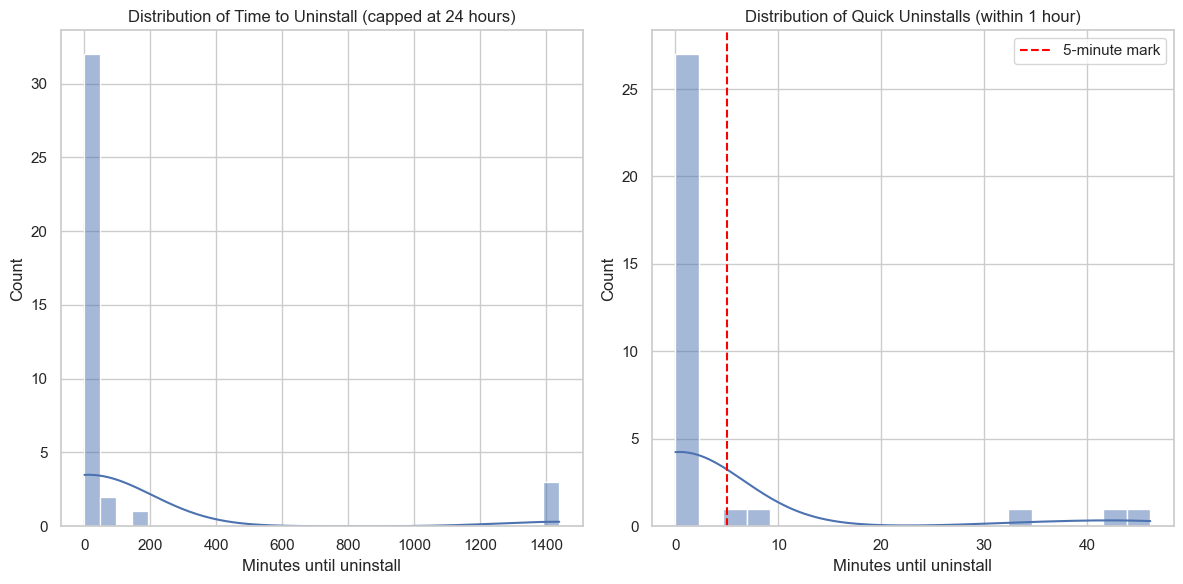

In [9]:
# Visualize uninstall time distribution
if not uninstall_df.empty:
    plt.figure(figsize=(12, 6))
    
    # Histogram for all uninstalls (capped at 24 hours = 1440 minutes for readability)
    plt.subplot(1, 2, 1)
    capped_times = uninstall_df['minutes_to_uninstall'].clip(upper=1440)  # Cap at 24 hours
    sns.histplot(capped_times, bins=30, kde=True)
    plt.title('Distribution of Time to Uninstall (capped at 24 hours)')
    plt.xlabel('Minutes until uninstall')
    plt.ylabel('Count')
    
    # Histogram focused on quick uninstalls (first hour)
    plt.subplot(1, 2, 2)
    sns.histplot(uninstall_df[uninstall_df['minutes_to_uninstall'] <= 60]['minutes_to_uninstall'], bins=20, kde=True)
    plt.axvline(x=5, color='red', linestyle='--', label='5-minute mark')
    plt.title('Distribution of Quick Uninstalls (within 1 hour)')
    plt.xlabel('Minutes until uninstall')
    plt.ylabel('Count')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

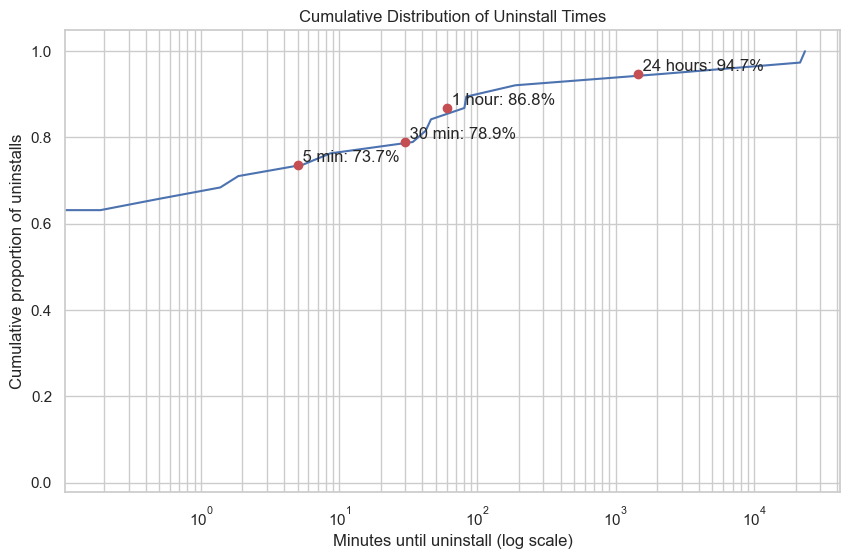

In [10]:
# Calculate cumulative percentage of uninstalls over time
if not uninstall_df.empty:
    # Sort uninstall times
    sorted_times = sorted(uninstall_df['minutes_to_uninstall'])
    
    # Calculate cumulative distribution
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    # Plot cumulative distribution
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times, y)
    
    # Add markers for specific time points
    time_markers = [5, 30, 60, 24*60]  # 5 min, 30 min, 1 hour, 24 hours
    marker_names = ['5 min', '30 min', '1 hour', '24 hours']
    
    for time, name in zip(time_markers, marker_names):
        idx = np.searchsorted(sorted_times, time)
        if idx < len(y):
            plt.plot(time, y[idx], 'ro')
            plt.text(time, y[idx], f' {name}: {y[idx]*100:.1f}%', verticalalignment='bottom')
    
    plt.title('Cumulative Distribution of Uninstall Times')
    plt.xlabel('Minutes until uninstall (log scale)')
    plt.ylabel('Cumulative proportion of uninstalls')
    plt.xscale('log')
    plt.grid(True, which="both", ls="-")
    plt.show()